# Questionnaire

The questionnaire to ask users at the end of the experiment.

Scale: {`Excellent`, `Good`, `Fair`, `Poor`}

1. Attainment of desired/interesting solution: did you find a solution that you consider interesting or that you had in mind before the beginning of the experiment?
2. System efficiency: was the system efficient in providing you with possible solutions?
3. User-friendliness: how user-friendly was the system?
4. Runtime response: how fast was the system when handling your requests?
5. User fatigue: how tiresome was the experiment?

In [1]:
n_volunteers = 10
n_questions = 5
n_categories = 4

questions_place = {
    'A': 'Attainment of desired/interesting solution',
    'B': 'System efficiency',
    'C': 'User-friendliness',
    'D': 'Runtime response',
    'E': 'User fatigue'
} 

scale = ['', 'Excellent', 'Good', 'Fair', 'Poor']

In [2]:
import numpy as np

responses = np.random.random((n_questions, n_categories))
responses /= np.sum(responses, axis=1)[:, None]
responses *= n_volunteers

C:\Users\rober\AppData\Local\Temp\ipykernel_8376\3338967711.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[plot_idx].set_xticklabels(scale)


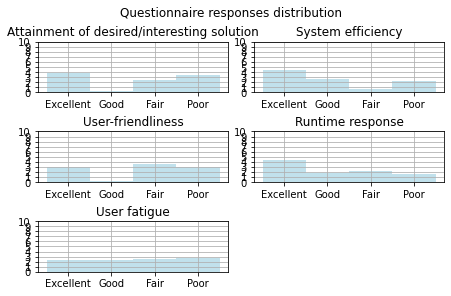

In [3]:
import matplotlib.pyplot as plt

axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AB
    CD
    E.
    """
)

for i in range(len(list(questions_place.keys()))):
    plot_idx = list(questions_place.keys())[i]
    axd[plot_idx].bar(np.arange(n_categories), responses[i], 1, color='lightblue', alpha=0.75)
    axd[plot_idx].set_xticklabels(scale)
    axd[plot_idx].set_yticks(np.arange(0, n_volunteers + 1, 1))
    axd[plot_idx].set_title(questions_place[plot_idx])
    axd[plot_idx].grid()

plt.suptitle('Questionnaire responses distribution')

plt.show()

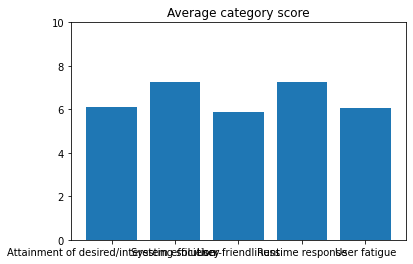

In [4]:
avg_response = np.mean(responses * [4,3,2,1], axis=1)

plt.bar(questions_place.values(), avg_response)
plt.ylim(0, n_volunteers)
plt.title('Average category score')
plt.show()

# Emitters ranking

Simulate the ranking of emitters per type and perform the statistical analysis.

In [5]:
import numpy as np

samples_name = ['random-emitter', 'preference-matrix-emitter', 'contextual-bandit-emitter']
samples_scores = {k:[] for k in samples_name}

for _ in range(n_volunteers):
    tmp = samples_name.copy()
    np.random.shuffle(tmp)
    score_v = len(samples_name)
    for emitter_type in tmp:
        samples_scores[emitter_type].append(score_v)# - np.ceil(len(samples_name) / 2))
        score_v -= 1

samples = [np.asarray(x) for x in samples_scores.values()]

## Shapiro-Wilk test

Shapiro-Wilk test for normality. We want the statistic to be as close to `1` as possible.

In [6]:
from pcgsepy.stats.tests import shapiro_wilk

print('## SHAPIRO-WILK TEST ##')

shapiro_test = shapiro_wilk(samples=samples)

for (stat, pvalue), name in zip(shapiro_test, samples_name):
    print(f'Result score for {name}:')
    print(f'\tStatistic: {stat}')
    print(f'\tp-value: {pvalue}')


## SHAPIRO-WILK TEST ##
Result score for random-emitter:
	Statistic: 0.7809399962425232
	p-value: 0.008499783463776112
Result score for preference-matrix-emitter:
	Statistic: 0.7559678554534912
	p-value: 0.0042188530787825584
Result score for contextual-bandit-emitter:
	Statistic: 0.8325026631355286
	p-value: 0.035864245146512985


## One-way ANOVA

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

In [7]:
import itertools
from pcgsepy.stats.tests import anova, THRESHOLD_PVALUE

print('## ONE-WAY ANOVA TEST ##')

anova_test = anova(samples=samples)

overall_stat, overall_pvalue = anova_test[0]

print('Overall score:')
print(f'\tStatistic: {overall_stat}')
print(f'\tp-value: {overall_pvalue}')

if overall_pvalue < THRESHOLD_PVALUE:
    for (stat, pvalue), name in zip(anova_test[1:], itertools.combinations(iterable=samples_name, r=2)):
        print(f'Result score for {" x ".join(list(name))}:')
        print(f'\tStatistic: {stat}')
        print(f'\tp-value: {pvalue}')

## ONE-WAY ANOVA TEST ##
Overall score:
	Statistic: 1.0161290322580645
	p-value: 0.3754220747544264


The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid:
- The samples are independent.
- Each sample is from a normally distributed population.
- The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

If these assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis H-test (scipy.stats.kruskal) or the Alexander-Govern test (scipy.stats.alexandergovern) although with some loss of power.

## Kruskal-Wallis H-test

In case the Shapiro-Wilk test fails, we resort to the Kruskal-Wallis H-test instead of one-way ANOVA.

In [8]:
from pcgsepy.stats.tests import kruskal_wallis, THRESHOLD_PVALUE

print('## KRUSKAL-WALLIS TEST ##')

kruskal_wallis_test = kruskal_wallis(samples=samples)

overall_stat, overall_pvalue = kruskal_wallis_test[0]

print('Overall score:')
print(f'\tStatistic: {overall_stat}')
print(f'\tp-value: {overall_pvalue}')

if overall_pvalue < THRESHOLD_PVALUE:
    for (stat, pvalue), name in zip(kruskal_wallis_test[1:], itertools.combinations(iterable=samples_name, r=2)):
        print(f'Result score for {" x ".join(list(name))}:')
        print(f'\tStatistic: {stat}')
        print(f'\tp-value: {pvalue}')

## KRUSKAL-WALLIS TEST ##
Overall score:
	Statistic: 2.0300000000000065
	p-value: 0.36240242983248905


## Ranking plotting

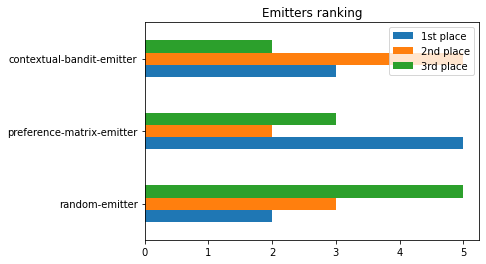

In [9]:
from pcgsepy.stats.plots import plot_rankings

plot_rankings(samples=samples,
              labels=['1st place', '2nd place', '3rd place'],
              names=samples_name,
              title='Emitters ranking')

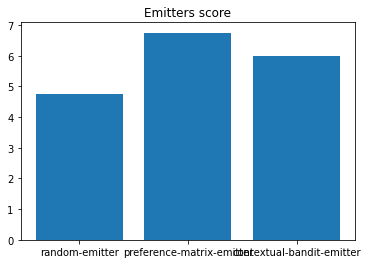

In [10]:
from pcgsepy.stats.plots import plot_scores

plot_scores(samples=samples,
            names=samples_name,
            score_to_value={1: 1, 2: 0.5, 3: 0.25},
            title='Emitters score'
            )